In [1]:
import os
import datetime
import warnings
warnings.filterwarnings('ignore')
import gc
import json

import pandas as pd
import numpy as np
import geopandas as gpd

from utils import process_data

In [192]:
from platform import python_version
python_version()

'3.9.12'

In [ ]:
!pip freeze > requirements.txt

In [2]:
bm = pd.read_csv('data/luminosity_urban_rural.csv')

avg_temp = pd.read_csv('data/average_temp_urban_rural_admin2_cleaned.csv')

max_temp = pd.read_csv('data/max_temp_urban_rural_admin2_cleaned.csv')

pm_25_sum = pd.read_csv('data/pollution_urban_rural_admin2.csv')

pm_25_avg = pd.read_csv('data/air_pollution_urban_rural.csv')

pop = pd.read_csv('data/population_vietnam_worldpop.csv')

poly = gpd.read_file('data/gadm40_VNM_2_full.geojson')
regions = pd.read_csv('data/region_list.csv')
provs = pd.read_csv('data/prov_list.csv')
districts = pd.read_csv('data/dist_list.csv')

zone = gpd.read_file('data/urban_rural/vietnam_urban_rural_polygon.shp')

In [3]:
pop_zone = pd.read_csv('data/pop_by_zone.csv')
pop_zone.columns = pop_zone.columns.str.upper()
pop_zone = pop_zone.rename({'CLSSFCT': 'POP_ZONE', 
                            'POPULATION_SUM': 'POPULATION'}, axis=1)
pop_zone.head()

,POP_ZONE,GID_2,YEAR,POPULATION
0,rural,VNM.1.10_1,2014,80486.359375
1,rural,VNM.1.11_1,2014,76966.218750
2,rural,VNM.1.1_1,2014,41436.687500
3,rural,VNM.1.2_1,2014,66939.007812
4,rural,VNM.1.3_1,2014,22985.164062


In [4]:
poly = poly.replace({'Qui Nhơn': 'Quy Nhơn',
                     'Qui Nhon': 'Quy Nhon'})
full_region = pd.merge(districts[['dist_name_en', 'prov_code']],
                       provs[['prov_code', 'prov_name_en', 'region_code']],
                       on=['prov_code'], how='left')
full_region = pd.merge(full_region, regions[['region_code', 'region_name_en']],
                       on=['region_code'], how='left')
full_region = pd.merge(full_region, poly[['NAME_1', 'ID_2']],
                       left_on='dist_name_en', right_on='ID_2', how='left')
full_region = full_region.drop(['dist_name_en', 'prov_code', 'region_code'], axis=1)
full_region = full_region.rename({'NAME_1': 'GID_2',
                                  'prov_name_en': 'NAME_1',
                                  'region_name_en': 'REGION_NAME',
                                  'ID_2': 'NAME_2'}, axis=1)
full_region.head()

,NAME_1,REGION_NAME,GID_2,NAME_2
0,Ha Noi,Red River Delta,VNM.27.3_1,Ba Dinh
1,Ha Noi,Red River Delta,VNM.27.14_1,Hoan Kiem
2,Ha Noi,Red River Delta,VNM.27.25_1,Tay Ho
3,Ha Noi,Red River Delta,VNM.27.16_1,Long Bien
4,Ha Noi,Red River Delta,VNM.27.5_1,Cau Giay


In [10]:
df_zone = process_data(bm, avg_temp, max_temp, pm_25_sum, pm_25_avg,
                  yearly=True, pop_zone=True)

df_zone = pd.merge(df_zone, pop_zone, on=['GID_2', 'YEAR', 'POP_ZONE'], how='left')
df_zone = df_zone[df_zone['YEAR'] < 2020]

cleaning data

aggregating data

combining data

rest of steps


In [11]:
pop.columns = pop.columns.str.upper()
df_tot = process_data(bm, avg_temp, max_temp, pm_25_sum, pm_25_avg,
                                yearly=True, pop_zone=False)
df_tot = pd.merge(df_tot, pop[['GID_2', 'YEAR', 'POPULATION']], 
              on=['GID_2', 'YEAR'],
              how='left')

df_tot = df_tot[df_tot['YEAR'] < 2020]
df_tot['POP_ZONE'] = 'total'

cleaning data

aggregating data

combining data

rest of steps


In [12]:
df = pd.concat([df_zone, df_tot], axis=0).reset_index(drop=True)

In [13]:
df

,GID_2,POP_ZONE,YEAR,COUNTRY,GID_1,NAME_1,NAME_2,LUMINOSITY_SUM,AVERAGE_TEMPERATURE,MAX_TEMPERATURE,AIR_POLLUTION,AIR_POLLUTION_AVG,LOG_LUMINOSITY_SUM,LUMINOSITY_PCT_CHANGE,AVG_TEMP_PCT_CHANGE,MAX_TEMP_PCT_CHANGE,AIR_POLLUTION_PCT_CHANGE,AIR_AVG_PCT_CHANGE,POP_ZONE_ENCODE,POPULATION
0,VNM.1.10_1,rural,2014,Vietnam,VNM.1_1,An Giang,Tho?i S?n,539.051075,26.992985,35.903061,63.223961,25.053337,6.289810,NaN,NaN,NaN,NaN,NaN,0.0,80486.359375
1,VNM.1.10_1,rural,2015,Vietnam,VNM.1_1,An Giang,Tho?i S?n,671.786930,27.478260,36.308628,66.771805,26.459219,6.509941,24.623985,1.797782,1.129617,5.611550,5.611555,0.0,79808.382812
2,VNM.1.10_1,rural,2016,Vietnam,VNM.1_1,An Giang,Tho?i S?n,820.089788,27.622874,38.085022,61.288029,24.286200,6.709414,22.075877,0.526285,4.892484,-8.212712,-8.212712,0.0,78264.539062
3,VNM.1.10_1,rural,2017,Vietnam,VNM.1_1,An Giang,Tho?i S?n,617.190737,26.711018,34.158653,57.978256,22.974657,6.425178,-24.741078,-3.301091,-10.309483,-5.400357,-5.400361,0.0,76876.125000
4,VNM.1.10_1,rural,2018,Vietnam,VNM.1_1,An Giang,Tho?i S?n,1173.742737,26.989017,35.335587,57.262222,22.690920,7.067953,90.175041,1.040766,3.445491,-1.235004,-1.235001,0.0,79557.515625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12433,VNM.9.9_1,total,2015,Vietnam,VNM.9_1,Bình D??ng,Thu?n An,79071.341309,27.192544,36.110855,18.299969,26.478746,11.278106,5.391903,1.304011,-1.455590,-1.458457,-1.458459,NaN,573542.727539
12434,VNM.9.9_1,total,2016,Vietnam,VNM.9_1,Bình D??ng,Thu?n An,82862.642578,27.345864,37.579525,19.091774,27.624434,11.324940,4.794786,0.563832,4.067115,4.326812,4.326818,NaN,614702.115234
12435,VNM.9.9_1,total,2017,Vietnam,VNM.9_1,Bình D??ng,Thu?n An,85914.017090,26.724937,36.245647,17.525928,25.358767,11.361102,3.682449,-2.270645,-3.549480,-8.201676,-8.201678,NaN,658302.111328
12436,VNM.9.9_1,total,2018,Vietnam,VNM.9_1,Bình D??ng,Thu?n An,92475.668945,27.040146,36.647247,17.471262,25.279667,11.434701,7.637464,1.179456,1.107995,-0.311918,-0.311922,NaN,703598.059570


In [14]:
del bm, avg_temp, max_temp, pm_25_sum, pm_25_avg, pop
gc.collect()

24

In [31]:
df['LPC'] = df['LUMINOSITY_SUM'] / (1 + df['POPULATION'])
df['APPC'] = df['AIR_POLLUTION'] / (1 + df['POPULATION'])

df = df.sort_values(by=['GID_2', 'POP_ZONE'], ascending=True)
df['LPC_PCT_CHANGE'] = \
                100*(df.groupby(['GID_2', 'POP_ZONE'])['LPC'].apply(pd.Series.pct_change))
df['APPC_PCT_CHANGE'] = \
                100*(df.groupby(['GID_2', 'POP_ZONE'])['APPC'].apply(pd.Series.pct_change))
df['POP_PCT_CHANGE'] = \
                100*(df.groupby(['GID_2', 'POP_ZONE'])['POPULATION'].apply(pd.Series.pct_change))

In [32]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [33]:
df[['LUMINOSITY_SUM', 'LOG_LUMINOSITY_SUM', 'LPC']].describe()

,LUMINOSITY_SUM,LOG_LUMINOSITY_SUM,LPC
count,1.243800e+04,12438.000000,12438.000000
mean,2.304771e+04,7.873961,0.530429
std,1.953134e+05,2.144278,7.485581
min,1.000000e+00,0.000000,0.000009
25%,7.856306e+02,6.666487,0.022960
50%,2.882957e+03,7.966572,0.059469
75%,1.134889e+04,9.336875,0.142334
max,7.449494e+06,15.823657,350.300403


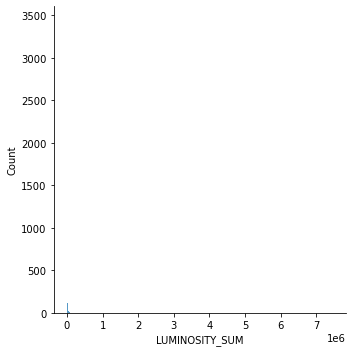

In [34]:
sns.displot(df, x='LUMINOSITY_SUM')

In [35]:
df1 = df[df['LUMINOSITY_SUM'] < 1e5]
df1[['LUMINOSITY_SUM', 'LOG_LUMINOSITY_SUM', 'LPC']].describe()

,LUMINOSITY_SUM,LOG_LUMINOSITY_SUM,LPC
count,12204.000000,12204.000000,12204.000000
mean,9378.966537,7.782657,0.386263
std,15740.291288,2.053134,7.204773
min,1.000000,0.000000,0.000009
25%,764.243655,6.638887,0.022527
50%,2739.319299,7.915465,0.057725
75%,10403.181616,9.249867,0.135465
max,99788.041992,11.510804,350.300403


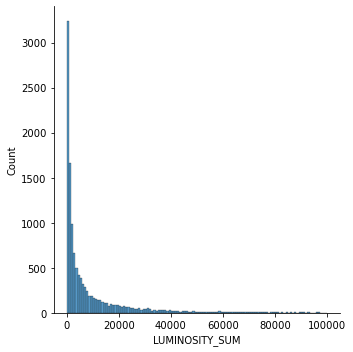

In [36]:
sns.displot(df1, x='LUMINOSITY_SUM')

In [43]:
df['LLPC'] = df['LOG_LUMINOSITY_SUM'] / df['POPULATION']
df['LLPC_PCT_CHANGE'] = \
                100*(df.groupby(['GID_2', 'POP_ZONE'])['LLPC'].apply(pd.Series.pct_change))

In [37]:
df.POP_ZONE.value_counts()

total    4260
urban    4134
rural    4044
Name: POP_ZONE, dtype: int64

In [38]:
del df1
gc.collect()

128

In [63]:
df.POP_ZONE.value_counts()

total    4260
urban    4134
rural    4044
Name: POP_ZONE, dtype: int64

In [72]:
df_fy

,GID_1,GID_2,POP_ZONE,YEAR,LLPC,LLPC_PCT_CHANGE,LOG_LUMINOSITY_SUM,LUMINOSITY_PCT_CHANGE,AVG_TEMP_PCT_CHANGE,MAX_TEMP_PCT_CHANGE,APPC,APPC_PCT_CHANGE,POPULATION,POP_PCT_CHANGE,ECON_SCORE,ENVR_SCORE
0,VNM.1_1,VNM.1.10_1,rural,2014,0.000078,NaN,6.289810,NaN,NaN,NaN,0.000786,NaN,80486.359375,NaN,50.945249,51.038576
8178,VNM.1_1,VNM.1.10_1,total,2014,0.000043,-0.956605,8.005595,NaN,NaN,NaN,0.000524,-4.947774,185171.470215,-0.347235,45.915493,55.070423
6,VNM.1_1,VNM.1.10_1,urban,2014,0.000075,-0.097301,7.807767,NaN,NaN,NaN,0.000323,5.906257,104601.744141,-2.781085,46.347363,62.264151
12,VNM.1_1,VNM.1.11_1,rural,2014,0.000086,-15.370053,6.632941,NaN,NaN,NaN,0.001296,2.311504,76966.218750,7.775565,54.557226,62.908012
8188,VNM.1_1,VNM.1.11_1,total,2014,0.000059,-1.895908,8.131281,-16.734561,-2.458699,-4.828715,0.000890,4.114922,136723.992188,-0.312659,46.854460,65.915493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8160,VNM.9_1,VNM.9.8_1,rural,2014,0.005847,3.542449,5.343165,NaN,NaN,NaN,0.000470,17.883131,913.855896,-10.707668,41.789498,28.486647
12430,VNM.9_1,VNM.9.8_1,total,2014,0.000032,37.909243,11.378163,-6.031285,-1.377213,1.637365,0.000071,50.185446,356729.956055,-29.503679,67.183099,8.309859
8166,VNM.9_1,VNM.9.8_1,urban,2014,0.000032,14.906401,11.375779,NaN,NaN,NaN,0.000069,12.065175,356237.230957,-13.740651,67.489115,9.724238
12432,VNM.9_1,VNM.9.9_1,total,2014,0.000021,13.828539,11.225590,-24.226875,-1.441190,1.952765,0.000035,11.702392,535287.170898,-12.919257,66.572770,5.211268


In [102]:
df_source = df[['GID_1', 'GID_2', 'POP_ZONE', 'YEAR', 
                'LLPC', 'LLPC_PCT_CHANGE', 
                'LOG_LUMINOSITY_SUM', 'LUMINOSITY_PCT_CHANGE',
                'AVG_TEMP_PCT_CHANGE', 'MAX_TEMP_PCT_CHANGE', 
                'APPC', 'APPC_PCT_CHANGE',
                'POPULATION', 'POP_PCT_CHANGE']]

f_fy_econ = 1 / 2
df_fy = df_source[df_source['YEAR'] == df_source['YEAR'].min()]
# (df_fy.groupby(['POP_ZONE', 'YEAR'])['LLPC'].rank(pct=True)*100)*f_fy_econ + \
df_fy['ECON_SCORE'] = (df_fy.groupby(['POP_ZONE', 'YEAR'])['LOG_LUMINOSITY_SUM'].rank(pct=True)*100)*f_fy_econ + \
                      (df_fy.groupby(['POP_ZONE', 'YEAR'])['POPULATION'].rank(pct=True)*100)*f_fy_econ
df_fy['ENVR_SCORE'] = (df_fy.groupby(['POP_ZONE', 'YEAR'])['APPC'].rank(pct=True, ascending=True)*100)

f_rest_econ = 1 / 4
f_rest_envr = 1 / 4
df_rest = df_source[df_source['YEAR'] != df_source['YEAR'].min()]
# (df_rest.groupby(['POP_ZONE', 'YEAR'])['LLPC'].rank(pct=True)*100)*f_rest_econ + \
# (df_rest.groupby(['POP_ZONE', 'YEAR'])['LLPC_PCT_CHANGE'].rank(pct=True)*100)*f_rest_econ + \
df_rest['ECON_SCORE'] = (df_rest.groupby(['POP_ZONE', 'YEAR'])['LOG_LUMINOSITY_SUM'].rank(pct=True)*100)*f_rest_econ + \
                        (df_rest.groupby(['POP_ZONE', 'YEAR'])['LUMINOSITY_PCT_CHANGE'].rank(pct=True)*100)*f_rest_econ + \
                        (df_rest.groupby(['POP_ZONE', 'YEAR'])['POPULATION'].rank(pct=True)*100)*f_rest_econ + \
                        (df_rest.groupby(['POP_ZONE', 'YEAR'])['POP_PCT_CHANGE'].rank(pct=True)*100)*f_rest_econ 

df_rest['ENVR_SCORE'] = (df_rest.groupby(['POP_ZONE', 'YEAR'])['AVG_TEMP_PCT_CHANGE'].rank(pct=True, ascending=False)*100)*f_rest_envr + \
                        (df_rest.groupby(['POP_ZONE', 'YEAR'])['MAX_TEMP_PCT_CHANGE'].rank(pct=True, ascending=False)*100)*f_rest_envr + \
                        (df_rest.groupby(['POP_ZONE', 'YEAR'])['APPC'].rank(pct=True, ascending=True)*100)*f_rest_envr + \
                        (df_rest.groupby(['POP_ZONE', 'YEAR'])['APPC_PCT_CHANGE'].rank(pct=True, ascending=True)*100)*f_rest_envr

df_source = pd.concat([df_fy, df_rest], axis=0).reset_index(drop=True)

df_source = pd.merge(df_source, full_region, on=['GID_2'], how='left')
df_source = df_source.drop_duplicates(subset=['GID_2', 'YEAR', 'POP_ZONE'])
df_source.head()

,GID_1,GID_2,POP_ZONE,YEAR,LLPC,LLPC_PCT_CHANGE,LOG_LUMINOSITY_SUM,LUMINOSITY_PCT_CHANGE,AVG_TEMP_PCT_CHANGE,MAX_TEMP_PCT_CHANGE,APPC,APPC_PCT_CHANGE,POPULATION,POP_PCT_CHANGE,ECON_SCORE,ENVR_SCORE,NAME_1,REGION_NAME,NAME_2
0,VNM.1_1,VNM.1.10_1,rural,2014,0.000078,NaN,6.289810,NaN,NaN,NaN,0.000786,NaN,80486.359375,NaN,70.771513,51.038576,An Giang,Mekong River Delta,Thoai Son
1,VNM.1_1,VNM.1.10_1,total,2014,0.000043,-0.956605,8.005595,NaN,NaN,NaN,0.000524,-4.947774,185171.470215,-0.347235,62.042254,55.070423,An Giang,Mekong River Delta,Thoai Son
2,VNM.1_1,VNM.1.10_1,urban,2014,0.000075,-0.097301,7.807767,NaN,NaN,NaN,0.000323,5.906257,104601.744141,-2.781085,53.701016,62.264151,An Giang,Mekong River Delta,Thoai Son
3,VNM.1_1,VNM.1.11_1,rural,2014,0.000086,-15.370053,6.632941,NaN,NaN,NaN,0.001296,2.311504,76966.218750,7.775565,74.480712,62.908012,An Giang,Mekong River Delta,Tri Ton
4,VNM.1_1,VNM.1.11_1,total,2014,0.000059,-1.895908,8.131281,-16.734561,-2.458699,-4.828715,0.000890,4.114922,136723.992188,-0.312659,53.661972,65.915493,An Giang,Mekong River Delta,Tri Ton


In [103]:
df_source.POP_ZONE.value_counts()

total    4260
urban    4134
rural    4044
Name: POP_ZONE, dtype: int64

In [104]:
import random
from bokeh.palettes import Bokeh7

pallete = list(Bokeh7)
random.shuffle(pallete)

In [105]:
df_color = pd.DataFrame({'REGION_NAME': df_source.REGION_NAME.unique(),
                         'COLOR': pallete[:df_source.REGION_NAME.nunique()]})
df_source = pd.merge(df_source, df_color, on=['REGION_NAME'], how='left')
df_source.head()

,GID_1,GID_2,POP_ZONE,YEAR,LLPC,LLPC_PCT_CHANGE,LOG_LUMINOSITY_SUM,LUMINOSITY_PCT_CHANGE,AVG_TEMP_PCT_CHANGE,MAX_TEMP_PCT_CHANGE,APPC,APPC_PCT_CHANGE,POPULATION,POP_PCT_CHANGE,ECON_SCORE,ENVR_SCORE,NAME_1,REGION_NAME,NAME_2,COLOR
0,VNM.1_1,VNM.1.10_1,rural,2014,0.000078,NaN,6.289810,NaN,NaN,NaN,0.000786,NaN,80486.359375,NaN,70.771513,51.038576,An Giang,Mekong River Delta,Thoai Son,#00AAAE
1,VNM.1_1,VNM.1.10_1,total,2014,0.000043,-0.956605,8.005595,NaN,NaN,NaN,0.000524,-4.947774,185171.470215,-0.347235,62.042254,55.070423,An Giang,Mekong River Delta,Thoai Son,#00AAAE
2,VNM.1_1,VNM.1.10_1,urban,2014,0.000075,-0.097301,7.807767,NaN,NaN,NaN,0.000323,5.906257,104601.744141,-2.781085,53.701016,62.264151,An Giang,Mekong River Delta,Thoai Son,#00AAAE
3,VNM.1_1,VNM.1.11_1,rural,2014,0.000086,-15.370053,6.632941,NaN,NaN,NaN,0.001296,2.311504,76966.218750,7.775565,74.480712,62.908012,An Giang,Mekong River Delta,Tri Ton,#00AAAE
4,VNM.1_1,VNM.1.11_1,total,2014,0.000059,-1.895908,8.131281,-16.734561,-2.458699,-4.828715,0.000890,4.114922,136723.992188,-0.312659,53.661972,65.915493,An Giang,Mekong River Delta,Tri Ton,#00AAAE


# Plotting

In [209]:
from bokeh.layouts import column, row
from bokeh.models import ColumnDataSource, Div, Select, Slider, TextInput, Label, RadioButtonGroup, TableColumn, Button
from bokeh.models import NumberFormatter, CustomJS
from bokeh.plotting import figure
from bokeh.sampledata.movies_data import movie_path
from bokeh.io import curdoc, show, output_notebook
from bokeh.application import Application
from bokeh.application.handlers import FunctionHandler
from bokeh.models.widgets import DataTable


In [210]:
output_notebook()

Loading BokehJS ...

In [220]:
region_list = ['All']
region_list.extend(list(df_source.REGION_NAME.unique()))

region = Select(title="Region", value="All",
               options=region_list, width=400)
year = Slider(title="Year", start=2014, end=2019, value=2014, step=1, width=400)
province = TextInput(title="Province name contains", width=400)
district = TextInput(title="District names contains", width=400)
ur_zone = RadioButtonGroup(labels=['Total', 'Urban', 'Rural'], active=0, width=400)

source = ColumnDataSource(data=dict(ECON_SCORE=[], ENVR_SCORE=[], YEAR=[], 
                                    NAME_1=[], NAME_2=[], REGION_NAME=[], 
                                    POP_ZONE=[], COLOR=[]))
columns = [
            TableColumn(field="NAME_1", title="Province"),
            TableColumn(field="NAME_2", title="District"),
            TableColumn(field="ECON_SCORE", title="Economic Score", formatter=NumberFormatter(format="0.")),
            TableColumn(field="ENVR_SCORE", title="Environment Score", formatter=NumberFormatter(format="0."))
        ]
source_table = DataTable(source=source, name="Table", 
                         columns=columns,
                         width=400, height=250)
source_table_div = Div(text="Score Table (Command + Click to deselect)",
                       width=400, align='start')
reset_button = Button(label="Refresh Button", width=400)


TOOLTIPS=[
    ("Province", "@NAME_1"),
    ("District", "@NAME_2"),
    ("Region", "@REGION_NAME"),
    ("Year", "@YEAR"),
    ("Economic Score", "@ECON_SCORE"),
    ("Environment Score", "@ENVR_SCORE")
]

p = figure(height=600, width=600, toolbar_location='above', 
           tooltips=TOOLTIPS, sizing_mode="scale_both",
           x_range=(-5.0, 105.0), y_range=(-5.0, 105.0),
           x_axis_label='Environment Score', y_axis_label='Economic Score',
           tools='reset, pan')
p.circle(x="ENVR_SCORE", y="ECON_SCORE", source=source, size=4, 
         line_color=None, color="COLOR", alpha=3)

p.xaxis.fixed_location = 50.0
p.yaxis.fixed_location = 50.0

x_label = Label(x=240, y=-0.4, x_units='screen', y_units='screen', text='Environment Score',render_mode='css', text_color='black', 
                text_font_size='15px', border_line_color='white', border_line_alpha=0, background_fill_color='white', 
                background_fill_alpha=1.0)
y_label = Label(x=18, y=220, x_units='screen', y_units='screen', text='Economic Score',render_mode='css', text_color='Black', 
                text_font_size='15px', border_line_color='white', border_line_alpha=0, background_fill_color='white', 
                background_fill_alpha=1.0, angle=90, angle_units='deg')

topleft1 = Label(x=27, y=555, x_units='screen', y_units='screen', text='Good Economy',render_mode='css', text_color='green', 
                 text_font_size='10px', border_line_color='white', border_line_alpha=0, background_fill_color='white', background_fill_alpha=0)
topleft2 = Label(x=27, y=545, x_units='screen', y_units='screen',text='Brown Environment ', render_mode='css',text_color='red', 
                 text_font_size='10px',border_line_color='white', border_line_alpha=0,background_fill_color='white', background_fill_alpha=0)

topright1 = Label(x=500, y=555, x_units='screen', y_units='screen',text='Good Economy',render_mode='css',text_color='green', 
                  text_font_size='10px',border_line_color='white', border_line_alpha=0,background_fill_color='white', background_fill_alpha=0)
topright2 = Label(x=500, y=545, x_units='screen', y_units='screen',text='Green Environment ',render_mode='css', 
                  text_color='green', text_font_size='10px',border_line_color='white', border_line_alpha=0,background_fill_color='white', background_fill_alpha=0)

botleft1 = Label(x=27, y=10, x_units='screen', y_units='screen',text='Bad Economy', render_mode='css',text_color='red', 
                 text_font_size='10px',border_line_color='white', border_line_alpha=0,background_fill_color='white', background_fill_alpha=0)
botleft2 = Label(x=27, y=0, x_units='screen', y_units='screen',text='Brown Environment ', render_mode='css',text_color='red', 
                 text_font_size='10px',border_line_color='white', border_line_alpha=0,background_fill_color='white', background_fill_alpha=0)

botright1 = Label(x=500, y=10, x_units='screen', y_units='screen',text='Bad Economy', render_mode='css',text_color='red', 
                  text_font_size='10px',border_line_color='white', border_line_alpha=0,background_fill_color='white', background_fill_alpha=0)
botright2 = Label(x=500, y=0, x_units='screen', y_units='screen',text='Green Environment ', render_mode='css',text_color='green', 
                  text_font_size='10px',border_line_color='white', border_line_alpha=0,background_fill_color='white', background_fill_alpha=0)

for citation in [x_label, y_label, topleft1, topleft2, topright1, topright2, botleft1, botleft2, botright1, botright2]:
    p.add_layout(citation)

In [221]:
def select_region():
    region_val = region.value
    province_val = province.value.strip()
    district_val = district.value.strip()
    ur_zone_val = ur_zone.active
    
    selected = df_source[
        df_source['YEAR'] == year.value
    ]
    if (region_val != "All"):
        selected = selected[selected.REGION_NAME.str.contains(region_val)==True]
    if (province_val != "All"):
        selected = selected[selected.NAME_1.str.contains(province_val)==True]
    if (district_val != "All"):
        selected = selected[selected.NAME_2.str.contains(district_val)==True]
    if (ur_zone_val == 0):
        selected = selected[selected.POP_ZONE == 'total']
    elif (ur_zone_val == 1):
        selected = selected[selected.POP_ZONE == 'urban']
    else:
        selected = selected[selected.POP_ZONE == 'rural']
    
    
    return selected


def update():
    df_sel = select_region()
    
    p.title.text = "%d data points" % len(df_sel)
    source.data = dict(
        ENVR_SCORE=df_sel["ENVR_SCORE"],
        ECON_SCORE=df_sel["ECON_SCORE"],
        NAME_1=df_sel["NAME_1"],
        NAME_2=df_sel["NAME_2"],
        REGION_NAME=df_sel["REGION_NAME"],
        YEAR=df_sel["YEAR"],
        POP_ZONE=df_sel["POP_ZONE"],
        COLOR=df_sel["COLOR"]
    )
    
def reset():
    df_reset = df_source[
        (df_source['YEAR'] == df_source['YEAR'].min()) & \
        (df_source['POP_ZONE'] == 'total')
    ]
    source.data = dict(
        ENVR_SCORE=df_reset["ENVR_SCORE"],
        ECON_SCORE=df_reset["ECON_SCORE"],
        NAME_1=df_reset["NAME_1"],
        NAME_2=df_reset["NAME_2"],
        REGION_NAME=df_reset["REGION_NAME"],
        YEAR=df_reset["YEAR"],
        POP_ZONE=df_reset["POP_ZONE"],
        COLOR=df_reset["COLOR"]
    )  
    
value_controls = [region, province, district, year]
for control in value_controls:
    control.on_change('value', lambda attr, old, new: update())
active_controls = [ur_zone]
for control in active_controls:
    control.on_change('active', lambda attr, old, new: update())
        
# controls = [reset_button, region, province, district, ur_zone, year, 
#             source_table_div, source_table]
controls = [region, province, district, ur_zone, year, 
            source_table_div, source_table]

inputs = column(*controls, width=320)

l = column(row(p, inputs), sizing_mode="scale_both")

update()  # initial load of the data
# reset_button.on_click(reset)

# https://stackoverflow.com/questions/53217654/how-to-get-interactive-bokeh-in-jupyter-notebook
def modify_doc(doc):
    doc.add_root(column(l, width=320))
    doc.title = "Sliders"
    

handler = FunctionHandler(modify_doc)
app = Application(handler)

In [222]:
# https://github.com/bokeh/bokeh/issues/8096
show(app, notebook_url='localhost:8888')

In [224]:
df_source.to_csv('data/source.csv', index=False)

6.1
2.4.2
1.4.2
